In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import json
import sys
import argparse
import nltk
from pprint import pprint
from tqdm import tqdm
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
os.makedirs("./data/preprocessed/", exist_ok=True)

In [3]:
sys.stdout.encoding

'UTF-8'

In [4]:
def setup_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_dir", required=True)
    return parser.parse_args()


def write_to_file(out_file, line):
    out_file.write(line+'\n')


def data_from_json(filename):
    """Loads JSON data from filename and returns"""
    with open(filename) as data_file:
        data = json.load(data_file)
    return data

def tokenize(sequence):
    tokens = [token.replace("``", '"').replace("''", '"').lower() for token in nltk.word_tokenize(sequence)]
    return tokens

def get_character_indices_mapping(context, context_tokens):
    
    acc = '' 
    current_token_idx = 0 # current word loc
    mapping = dict()
    
    for char_idx, char in enumerate(context):
        if(char != ' ' and char != '\n'):
            acc += char
            context_token = context_tokens[current_token_idx] # current word token
            if(acc == context_token):
                start_ind = char_idx - len(acc) + 1
                for char_loc in range(start_ind, char_idx+1):
                    mapping[char_loc] = (acc, current_token_idx)
                acc = ''
                current_token_idx += 1
               

    if(current_token_idx != len(context_tokens)):
        return None
    else:
        return mapping
    
def total_exs(dataset):
    """
    Returns the total number of (context, question, answer) triples,
    given the data read from the SQuAD json file.
    """
    total = 0
    for article in dataset['data']:
        for para in article['paragraphs']:
            total += len(para['qas'])
    return total

    
def preprocess_and_write(dataset, devOrTrain, out_dir):
    
    num_exs = 0 # number of examples written to file
    num_mappingprob, num_tokenprob, num_spanalignprob, num_impossibleqs = 0, 0, 0, 0
    examples = []

    for articles_id in tqdm(range(len(dataset['data'])), desc="Preprocessing {}".format(devOrTrain)):
        article_paragraphs = dataset['data'][articles_id]['paragraphs']
        
        for pid in range(len(article_paragraphs)):
            context = article_paragraphs[pid]['context'] # string
            
            context = context.replace("''", '" ')
            context = context.replace("``", '" ')

            context_tokens = tokenize(context) # list of strings (lowercase)
            context = context.lower()
            
            qas = article_paragraphs[pid]['qas'] # list of questions
            charloc2wordloc = get_character_indices_mapping(context, context_tokens)
             
            if charloc2wordloc is None: # there was a problem
                num_mappingprob += len(qas)
                continue # skip this context example

            # for each question, process the question and answer and write to file
            
            for qn in qas:
                question = qn['question'] # string
                question_tokens = tokenize(question) 
                

                # of the three answers, just take the first
                # if it is impossible
                if(qn["is_impossible"] == True):
                    num_impossibleqs +=1 
                else:
                    ans_text = (qn['answers'][0]['text']).lower()
                    ans_start_charloc = qn['answers'][0]['answer_start'] 
                    ans_end_charloc = ans_start_charloc + len(ans_text) 
                
                    if context[ans_start_charloc:ans_end_charloc] != ans_text:
                        num_spanalignprob += 1
                        continue
                    
                    ans_start_wordloc = charloc2wordloc[ans_start_charloc][1] # answer start word loc
                    ans_end_wordloc = charloc2wordloc[ans_end_charloc-1][1] # answer end word loc
                    assert ans_start_wordloc <= ans_end_wordloc
                    
                    ans_tokens = context_tokens[ans_start_wordloc:ans_end_wordloc+1]
                    if "".join(ans_tokens) != "".join(ans_text.split()):
                        num_tokenprob += 1
                        continue # skip this question/answer pair

                    examples.append((' '.join(context_tokens), ' '.join(question_tokens), ' '.join(ans_tokens), ' '.join([str(ans_start_wordloc), str(ans_end_wordloc)])))
                    num_exs += 1
                
    print("Number of (context, question, answer) triples discarded due to char -> token mapping problems: ", num_mappingprob)
    print("Number of (context, question, answer) triples discarded because character-based answer span is unaligned with tokenization: ", num_tokenprob)
    print("Number of (context, question, answer) triples discarded due character span alignment problems (usually Unicode problems): ", num_spanalignprob)
    print("Number of (context, question, answer) triples with impossible answers: ", num_impossibleqs)
    print("Processed %i examples of total %i\n" % (num_exs, num_exs + num_mappingprob + num_tokenprob + num_spanalignprob + num_impossibleqs))

    # shuffle examples
    indices = list(range(len(examples)))
    np.random.shuffle(indices)

    with open(os.path.join(out_dir, devOrTrain +'.context'), 'w') as context_file,  \
         open(os.path.join(out_dir, devOrTrain +'.question'), 'w') as question_file,\
         open(os.path.join(out_dir, devOrTrain +'.answer'), 'w') as ans_text_file, \
         open(os.path.join(out_dir, devOrTrain +'.span'), 'w') as span_file:

        for i in indices:
            (context, question, answer, answer_span) = examples[i]

            # write tokenized data to file
            write_to_file(context_file, context)
            write_to_file(question_file, question)
            write_to_file(ans_text_file, answer)
            write_to_file(span_file, answer_span)

        

In [5]:
data_folder_name= "data"

if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)
    
train_filename = "train-v2.0.json"
dev_filename = "dev-v2.0.json"

train_data_dir = "./data/"
dev_data_dir = "./data/"

In [6]:
train_data = data_from_json(os.path.join(train_data_dir, train_filename))
print("Train data has %i examples total" % total_exs(train_data))
dev_data = data_from_json(os.path.join(dev_data_dir, dev_filename))
print("Dev data has %i examples total" % total_exs(dev_data))

Train data has 130319 examples total
Dev data has 11873 examples total


In [7]:
preprocess_and_write(dev_data, 'dev', "./data/preprocessed/")

Preprocessing dev: 100%|██████████| 35/35 [00:02<00:00, 13.80it/s]

Number of (context, question, answer) triples discarded due to char -> token mapping problems:  0
Number of (context, question, answer) triples discarded because character-based answer span is unaligned with tokenization:  71
Number of (context, question, answer) triples discarded due character span alignment problems (usually Unicode problems):  0
Number of (context, question, answer) triples with impossible answers:  5945
Processed 5857 examples of total 11873



In [8]:
preprocess_and_write(train_data, 'train', "./data/preprocessed/")

Preprocessing train: 100%|██████████| 442/442 [00:40<00:00, 10.89it/s]


Number of (context, question, answer) triples discarded due to char -> token mapping problems:  147
Number of (context, question, answer) triples discarded because character-based answer span is unaligned with tokenization:  1156
Number of (context, question, answer) triples discarded due character span alignment problems (usually Unicode problems):  23
Number of (context, question, answer) triples with impossible answers:  43448
Processed 85545 examples of total 130319



In [9]:
train_context = os.path.join("./data/preprocessed/","train.context")

context_len = []

with open(train_context) as fp:  
    lines = fp.readlines()
    print(len(lines))
    for line in lines:
        words = len(line.split())
        context_len.append(words)

85545


In [10]:
context_len[0:10]

[142, 119, 209, 84, 33, 156, 107, 93, 382, 103]

/home/pallavi/git/course/nlpclass-1207-g-enigma/project/qa_env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


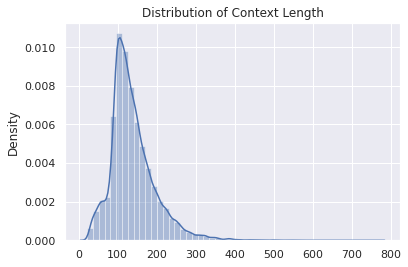

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
ax = sns.distplot(context_len)
ax.set_title('Distribution of Context Length')
ax.set_ylabel('Density')
plt.savefig('./assets/context_length.png')
plt.show()

In [12]:
context_array = np.array(context_len)

print("Min:   ", np.min(context_array))
print("Max:   ", np.max(context_array))
print("Mean:   ", np.mean(context_array))
print("25th percentile:   ", np.percentile(context_array, 25))
print("Median:            ", np.median(context_array))
print("75th percentile:   ", np.percentile(context_array, 75))
print("95th percentile:   ", np.percentile(context_array, 95))
print("99th percentile:   ", np.percentile(context_array, 99))

Min:    22
Max:    766
Mean:    137.91703781635397
25th percentile:    102.0
Median:             127.0
75th percentile:    164.0
95th percentile:    245.0
99th percentile:    324.5599999999977


In [13]:
train_ques = os.path.join("./data/preprocessed/","train.question")

ques_len = []
train_ans = os.path.join("./data/preprocessed/","train.answer")

ans_len = []

with open(train_ans) as fp:  
    lines = fp.readlines()
    print(len(lines))
    for line in lines:
        words = len(line.split())
        ans_len.append(words)
with open(train_ques) as fp:  
    lines = fp.readlines()
    print(len(lines))
    for line in lines:
        words = len(line.split())
        ques_len.append(words)

85545
85545


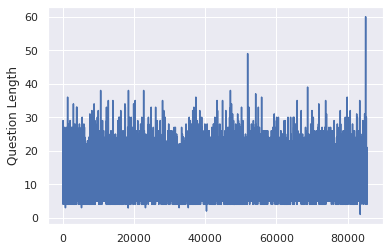

In [14]:
plt.plot(ques_len)
plt.ylabel('Question Length')
plt.show()

/home/pallavi/git/course/nlpclass-1207-g-enigma/project/qa_env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


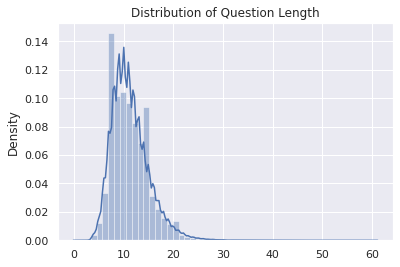

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
ax = sns.distplot(ques_len)
ax.set_title('Distribution of Question Length')
ax.set_ylabel('Density')
plt.savefig('./assets/question_length.png')
plt.show()

In [16]:
ques_array = np.array(ques_len)

print("Min:   ", np.min(ques_array))
print("Max:   ", np.max(ques_array))
print("Mean:   ", np.mean(ques_array))
print("25th percentile:   ", np.percentile(ques_array, 25))
print("Median:            ", np.median(ques_array))
print("75th percentile:   ", np.percentile(ques_array, 75))
print("95th percentile:   ", np.percentile(ques_array, 95))
print("99th percentile:   ", np.percentile(ques_array, 99))

Min:    1
Max:    60
Mean:    11.296019638786603
25th percentile:    9.0
Median:             11.0
75th percentile:    13.0
95th percentile:    18.0
99th percentile:    23.0


In [17]:
train_ans = os.path.join("./data/preprocessed","train.answer")

ans_len = []

with open(train_ans) as fp:  
    lines = fp.readlines()
    print(len(lines))
    for line in lines:
        words = len(line.split())
        ans_len.append(words)

85545


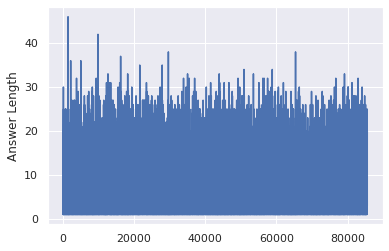

In [18]:
plt.plot(ans_len)
plt.ylabel('Answer Length')
plt.show()

In [19]:
ans_array = np.array(ans_len)

print("Min:   ", np.min(ans_array))
print("Max:   ", np.max(ans_array))
print("Mean:   ", np.mean(ans_array))
print("25th percentile:   ", np.percentile(ans_array, 25))
print("Median:            ", np.median(ans_array))
print("75th percentile:   ", np.percentile(ans_array, 75))
print("95th percentile:   ", np.percentile(ans_array, 95))
print("99th percentile:   ", np.percentile(ans_array, 99))

Min:    1
Max:    46
Mean:    3.3839499678531766
25th percentile:    1.0
Median:             2.0
75th percentile:    4.0
95th percentile:    11.0
99th percentile:    21.0


/home/pallavi/git/course/nlpclass-1207-g-enigma/project/qa_env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


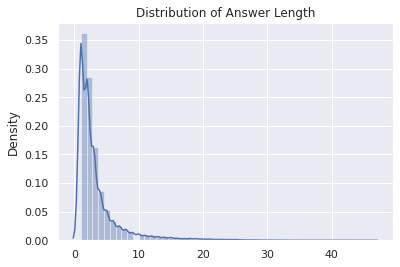

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
ax = sns.distplot(ans_len)
ax.set_title('Distribution of Answer Length')
ax.set_ylabel('Density')
plt.savefig('./assets/answer_length.png')
plt.show()

In [21]:
train_ans = os.path.join("./data/preprocessed","./assets/train.span")

ans_start = []
ans_end = []

with open(train_ans) as fp:  
    lines = fp.readlines()
    print(len(lines))
    for line in lines:
        words = line.split()
        ans_start.append(int(words[0]))
        ans_end.append(int(words[1]))

FileNotFoundError: [Errno 2] No such file or directory: './data/preprocessed/./assets/train.span'

In [ ]:
ans_start_array = np.array(ans_start)
ans_start_relative = np.true_divide(ans_start_array, context_array)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
ax = sns.distplot(ans_start_relative)
ax.set_title('Distribution of Answer Start Index relative to Context Length')
ax.set_ylabel('Answer Start Idx ratio')
plt.savefig('./assets/answer_start_ratio.png')
plt.show()